# Analysis of Tour de France data
Gian Carlo Diluvi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import scipy.stats as stats
from scipy.special import gammaln
import pystan
matplotlib.rcParams['font.size'] = 18

In [3]:
data = pd.read_csv('tour-de-france-data.csv')
data

,rank,rider,rider_number,team,time,bonus,penalty,stage,date,distance,...,winner_country,general,points,mountains,young,stage_winner,time_seconds,cumtime,gc_rank,timediff
0,1,Alexander Kristoff,135,Uae Team Emirates,3H 46M 13S,10,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13573,13573,1,0
1,2,Mads Pedersen,105,Trek - Segafredo,3H 46M 17S,6,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13577,13577,2,4
2,3,Cees Bol,203,Team Sunweb,3H 46M 19S,4,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13579,13579,3,6
3,4,Sam Bennett,43,Deceuninck - Quick - Step,3H 46M 23S,0,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13583,13583,4,10
4,5,Peter Sagan,21,Bora - Hansgrohe,3H 46M 23S,0,0,1,2020-08-29,156.0,...,NOR,135,135,185,105,135.0,13583,13583,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,142,Jasper De Buyst,153,Lotto Soudal,2H 53M 32S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10412,334992,142,10
3386,143,Marco Haller,65,Bahrain - Mclaren,2H 53M 32S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10412,335192,143,10
3387,144,Caleb Ewan,151,Lotto Soudal,2H 53M 32S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10412,335430,144,10
3388,145,Frederik Frison,156,Lotto Soudal,2H 55M 42S,0,0,21,2020-09-20,122.0,...,IRL,131,43,131,131,43.0,10542,336113,145,140


## Model

Our new model for the data sets:
- the mean to be a linear function of the house size
- the standard deviation to be a quadratic function of the house size

Observations: $y_i = \beta_0 + \beta_1 x_i + \epsilon_i$ 

Noise: $\epsilon_i \sim \mathcal{N}(0, \sigma_i^2)$ where $\sigma_i = (\gamma_0+\gamma_1 x_i)^2$

We will use the subjective prior from class:

$\beta_0 \sim \mathcal{N}(10^5, (2\times 10^5)^2)$

$\beta_1 \sim \mathcal{N}(10, 1000^2)$

$\gamma_0 \sim \mathcal{N}(3\times 10^4, (10^5)^2)$

$\gamma_1 \sim \mathcal{N}(0, 1000^2)$

*Note: we specify the variances above, e.g., 1000^2 for standard deviation 1000. Stan uses a different convention: `normal(mean, standard deviation)`.*

## Problem 1: Stan Code

In order to use Stan to sample from our posterior distribution, we need to specify the model in the Stan probabilistic programming language. We have provided a nearly complete template for you below; you just need to fill in the formula for the mean and standard deviation, and the distributions for $\beta_0,\beta_1,\gamma_0,\gamma_1,y$.

In [18]:
stan_code = """
data {
  int<lower=0> N; // number of observations
  int<lower=0> K;   // number of predictors
  vector[N] y; // responses
  matrix[N, K] x; // predictors
}
parameters {
  real alpha;           // intercept
  vector[K] beta;       // coefficients for predictors
  real<lower=0> gamma0;
  vector[K] gamma;       // coefficients for variance predictors 
}
model {

  alpha ~ normal(1e5, 2e5);
  gamma0 ~ normal(3e4, 1e5);
  
  for (k in 1:K){
      
      beta[k] ~ normal(0, 1e10);
      gamma[k] ~ normal(0, 1e10);
  }
  
  y ~ normal(alpha + x*beta, gamma0 + x*gamma);
}
"""

In [ ]:
transformed parameters {
  real mu[n];
  real<lower=0> sig[n];
  for (i in 1:n){
      
      mu[i] = alpha + beta*x[i];
      sig[i] = (gamma0 + gamma1*x[i])^2;
  }
}

The next code block builds the Stan model. Run this now.

*Note: This step is fairly slow. This is actually creating C++ code and running the compiler under the hood -- this is why Stan runs quite quickly!*

In [19]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_05a0bd846cf81c25d0298ce3f828f2d2 NOW.


The next code block passes the observed data to Stan, and runs the sampler.

*Note: by specifying `chains=10`, we are telling Stan to run 10 independent chains to draw samples -- having multiple chains will let us run the Gelman-Rubin diagnostic afterward. Also, specifying `iter=10000` tells Stan to collect `5000` samples in each chain; `5000` are used as "warmup" / "burn-in".*

*Note 2: If `iter=10000` takes too long on your computer, you can reduce this.*

In [23]:
stan_data = {'y': data.cumtime,
             'x': data[['stage', 'distance']],
             'N': data.shape[0],
             'K': 2}
fit = model.sampling(data=stan_data, iter=10000, chains=10)

KeyboardInterrupt: 

## Problem 2: Summary Statistics

Finally, we print the summary statistics of the samples that we took, and extract the raw sample sequences.

Discuss with your neighbour:
- Did the Gelman-Rubin diagnostic test pass?
- How many samples did we throw away as warmup / burn-in? How many samples did we take? How many "effective samples" (attempting to account for Markov chain autocorrelation) did we get? 
- What does the standard error (`se_mean`) refer to here?
- What does standard deviation (`sd`) refer to here?
- What do the percentiles refer to here?
- Does the posterior suggest that the standard deviation in house price grows with house size?

In [9]:
print(fit.stansummary(pars=['beta0','beta1','gamma0','gamma1']))
samples = fit.extract()

Inference for Stan model: anon_model_ce4cc0c1070b75f18953fd55da7769a1.
10 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=50000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0   2.7e4   15.07 2235.4  2.2e4  2.5e4  2.7e4  2.8e4  3.1e4  21994    1.0
beta1    8.19  3.5e-3   0.52   7.18   7.84   8.19   8.54    9.2  21711    1.0
gamma0  82.54    0.04    5.9  71.19  78.51  82.49  86.47  94.33  22923    1.0
gamma1   0.01  8.0e-6 1.2e-3 9.8e-3   0.01   0.01   0.01   0.01  23116    1.0

Samples were drawn using NUTS at Wed Nov 25 10:56:08 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Gian Carlo's comments

- Gelman-Rubin passed the thest for all params
- 5000 samples were used as warmup
- sd refers to the standard deviation of the posterior distribution of the corresponding parameter
- the percentiles correspond to the posterior percentiles - we can get credible intervals out of them, for example
- because gamma1 is positive, the std deviation in house price does grow with the house size

## Visualization

Use the below code to plot a visualization of the posterior distribution.

Discuss with your neighbour:
- What does the first plot show? What does the second plot show? 
- How much uncertainty is there in the posterior mean and standard deviation functions?
- Does the posterior suggest that the standard deviation grows with the house size?

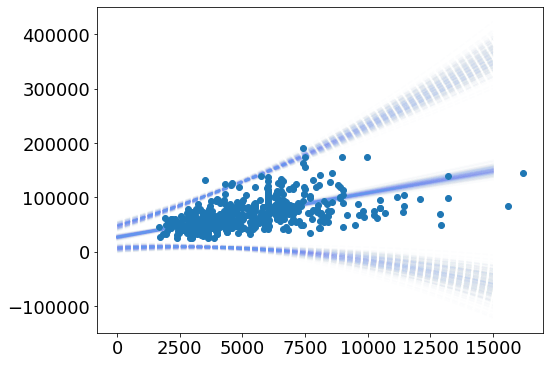

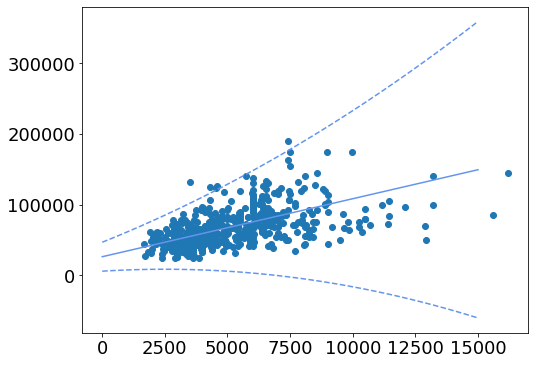

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(data['lotsize'], data['price'])
xs = np.linspace(0, 15000, 100)
#plot the first 300 samples (Stan shuffles the samples for you by default, so these are already in random order!)
for i in range(300):
    means = samples['beta0'][i] + samples['beta1'][i]*xs
    sigs = (samples['gamma0'][i] + samples['gamma1'][i]*xs)**2
    ax.plot(xs, means, color='cornflowerblue', alpha=0.01)
    ax.plot(xs, means+3*sigs, color='cornflowerblue', alpha=0.01, linestyle='--')
    ax.plot(xs, means-3*sigs, color='cornflowerblue', alpha=0.01, linestyle='--')
    
#plot the posterior mean
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(data['lotsize'], data['price'])
xs = np.linspace(0, 15000, 100)
means = samples['beta0'].mean() + samples['beta1'].mean()*xs
sigs = (samples['gamma0'].mean() + samples['gamma1'].mean()*xs)**2
ax.plot(xs, means, color='cornflowerblue')
ax.plot(xs, means+3*sigs, color='cornflowerblue', linestyle='--')
ax.plot(xs, means-3*sigs, color='cornflowerblue', linestyle='--')

### Gian Carlo's comments

- the first plot shoes multiple draws from the model, including "error bars" given by the $\pm$ 3 standard deviations from the means of the posterior params; the second plot shows the posterior means with $\pm$ 3 std deviations
- we seem to be fairly more certain about the posterior mean than about the variance
- the variance does grow with the lot size

## A minor tweak...

What happens if you change the following two lines in the stan code?

- Change `real<lower=0> gamma0;` to `real gamma0;`
- Change `real<lower=0> gamma1;` to `real gamma1;`

Make those changes in the code above and re-run the notebook. Discuss what happens with your neighbour. Why do we need to specify a lower bound on `gamma0` and `gamma1`?

### Gian Carlo's comments

the posterior values of $\gamma_i$ can take negative values!! It doesn't affect the model that much because we are squaring it, but it certainly goes against what our intuition would say...